# Custom LeNet Model

## This notebook has the following sections:

1. Prerequisites

2. Grid Search

3. Training using the Best Hyperparameters

4. Model Evaluation using a Confusion Matrix

5. Model Evaluation using K-Fold Cross Validation

# Section 1 - Prerequisites

In this section, we will import all the necessary libraries to run the notebook, define constants and invariants, and define the architecture of our model.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd

# Loading Datasets and Models
from keras.utils import image_dataset_from_directory
from keras.saving import load_model

# Saving Results
import os
import json

# Building our Model
from keras import Sequential
from keras.layers import Input, Rescaling, Conv2D, AveragePooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.regularizers import l2

# Compiling our Model
from keras.optimizers import SGD, Adam, RMSprop

# Grid Search
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV

# Confusion Matrix
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# K-Fold
from sklearn.model_selection import KFold

In [3]:
"""
Constants and Invariant Parameters
"""
# Invariant parameters
BATCH_SIZE = 16
EPOCHS = 10 # Due to limited hardware, we will only compute up to 10 epochs for realistic runtime constraints
VALIDATION_SPLIT = 0.2
SEED = 42

# Model tuning and evaluation
GRID_SEARCH_ITERATIONS = 3 # Number of attempts per hyperparameter combination (the score of these attempts will be averaged)
K_FOLDS = 5

# Constants
IMAGE_SIZE = (150, 150)
OPTIMIZERS = {
    "Adam": Adam,
    "SGD": SGD,
    "RMSprop": RMSprop,
}

# File and directory management
INPUT_DIRECTORY = "training_and_validation_dataset"
TESTING_DIRECTORY = "testing_dataset"
MODEL_NAME = "CustomLeNet"

In [4]:
"""
Define the model architecture
"""
def create_model(optimizer="SGD", learning_rate=0.001):
    model = Sequential([
        Input(shape=IMAGE_SIZE + tuple([3])), # (150, 150, 3)

        Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        AveragePooling2D(2, 2),
        Dropout(0.25),

        Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        AveragePooling2D(2, 2),
        Dropout(0.25),

        Flatten(),
        Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])

    optimizer = OPTIMIZERS[optimizer]

    model.compile(
        optimizer=optimizer(learning_rate=learning_rate),
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )

    return model

# Section 2 - Grid Search
In this section, we will perform grid search on our model to tune our chosen hyperparameters. The best hyperparameter configuration will be determined and saved into a .csv file.

In [5]:
"""
Define hyperparameter grid
"""
# Use the model prefix for compatibility with the GridSearch API
param_grid = {
    "model__optimizer": ["Adam", "SGD", "RMSprop"],
    "model__learning_rate": [0.0001, 0.001, 0.01, 0.1]
}

In [8]:
"""
Load the training dataset
"""
training_dataset = image_dataset_from_directory(
    INPUT_DIRECTORY,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    subset="training",
    validation_split=VALIDATION_SPLIT,
    seed=SEED,
)
validation_dataset = image_dataset_from_directory(
    INPUT_DIRECTORY,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    subset="validation",
    validation_split=VALIDATION_SPLIT,
    seed=SEED,
)

Found 712 files belonging to 2 classes.
Using 570 files for training.
Found 712 files belonging to 2 classes.
Using 142 files for validation.


In [8]:
"""
Prepare the data to be compatible with the GridSearch API
"""

# Function to convert TF dataset to NumPy arrays
def dataset_to_numpy(dataset):
    all_images, all_labels = [], []
    for images, labels in dataset:
        all_images.append(images.numpy())  # Convert images to NumPy
        all_labels.append(labels.numpy())  # Convert labels to NumPy
    return np.vstack(all_images), np.hstack(all_labels)

# Convert datasets for GridSearch compatibility
training_images, training_labels = dataset_to_numpy(training_dataset)
validation_images, validation_labels = dataset_to_numpy(validation_dataset)

# Wrap model for GridSearch compatibility
model = KerasClassifier(model=create_model, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1)

In [10]:
"""
Perform Grid Search
"""
grid = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=GRID_SEARCH_ITERATIONS
)
grid_result = grid.fit(
    training_images,
    training_labels,
    validation_data=(
        validation_images,
        validation_labels
    )
)

# Output best parameters
print(f"Best Params: {grid_result.best_params_}")
print(f"Best Score: {grid_result.best_score_}")

Epoch 1/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 163ms/step - accuracy: 0.7157 - loss: 1.0251 - val_accuracy: 0.8099 - val_loss: 0.9439
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step - accuracy: 0.8581 - loss: 0.6316 - val_accuracy: 0.8380 - val_loss: 0.6423
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - accuracy: 0.9411 - loss: 0.4776 - val_accuracy: 0.8028 - val_loss: 0.6794
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - accuracy: 0.9576 - loss: 0.4088 - val_accuracy: 0.8662 - val_loss: 0.5956
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step - accuracy: 0.9836 - loss: 0.3816 - val_accuracy: 0.8803 - val_loss: 0.5388
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 110ms/step - accuracy: 0.9865 - loss: 0.3466 - val_accuracy: 0.8732 - val_loss: 0.5184
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 116ms/step - accuracy: 0.9978 - loss: 0.3214 - val_accuracy: 0.8873 - val_loss: 0.5271
Epoch 8/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step - accuracy: 0.9982 - loss: 0.3140 - val_accuracy: 0.

2025-03-22 15:23:20.151865: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Epoch 1/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 0.6816 - loss: 1.3996 - val_accuracy: 0.7465 - val_loss: 1.1538
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - accuracy: 0.8143 - loss: 0.7190 - val_accuracy: 0.7465 - val_loss: 2.2194
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 109ms/step - accuracy: 0.9073 - loss: 0.5268 - val_accuracy: 0.8239 - val_loss: 1.0493
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 110ms/step - accuracy: 0.9214 - loss: 0.4670 - val_accuracy: 0.8521 - val_loss: 0.6711
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step - accuracy: 0.9525 - loss: 0.4453 - val_accuracy: 0.8521 - val_loss: 0.7089
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step - accuracy: 0.9747 - loss: 0.3789 - val_accuracy: 0.9014 - val_loss: 0.6180
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 0.9713 - loss: 0.3739 - val_accuracy: 0.9296 - val_loss: 0.5510
Epoch 8/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/step - accuracy: 

2025-03-22 15:24:21.716070: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 0.5389 - loss: 1.1503 - val_accuracy: 0.6620 - val_loss: 1.1945
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 105ms/step - accuracy: 0.7064 - loss: 0.9227 - val_accuracy: 0.6831 - val_loss: 0.8774
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step - accuracy: 0.6927 - loss: 0.9740 - val_accuracy: 0.7606 - val_loss: 0.8113
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step - accuracy: 0.7567 - loss: 0.8411 - val_accuracy: 0.7958 - val_loss: 0.7761
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 100ms/step - accuracy: 0.8184 - loss: 0.7336 - val_accuracy: 0.8028 - val_loss: 0.7555
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 100ms/step - accuracy: 0.7798 - loss: 0.7911 - val_accuracy: 0.8099 - val_loss: 0.7346
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 100ms/step - accuracy: 0.8080 - loss: 0.7362 - val_accuracy: 0.8239 - val_loss: 0.7229
Epoch 8/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 99ms/step - accuracy: 0.8054 - loss: 0.7069 - val_accuracy: 0.8239 - val_l

2025-03-22 15:25:40.331545: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
Epoch 1/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 142ms/step - accuracy: 0.6403 - loss: 2.0457 - val_accuracy: 0.7817 - val_loss: 1.0222
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 116ms/step - accuracy: 0.8518 - loss: 0.6577 - val_accuracy: 0.8451 - val_loss: 0.8420
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step - accuracy: 0.8912 - loss: 0.5897 - val_accuracy: 0.8592 - val_loss: 0.7327
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 109ms/step - accuracy: 0.9311 - loss: 0.4816 - val_accuracy: 0.8662 - val_loss: 0.7468
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - accuracy: 0.9437 - loss: 0.4416 - val_accuracy: 0.8662 - val_loss: 0.5593
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 108ms/step - accuracy: 0.9670 - loss: 0.3732 - val_accuracy: 0.8803 - val_loss: 0.5475
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 109ms/step - accuracy: 0.9805 - loss: 0.3390 - val_accuracy: 0.8873 - val_loss: 0.6067
Epoch 8/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 109ms/step - accuracy: 

2025-03-22 15:26:40.491487: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 184ms/step - accuracy: 0.7251 - loss: 4.4201 - val_accuracy: 0.8380 - val_loss: 2.3241
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 0.8230 - loss: 1.7612 - val_accuracy: 0.8310 - val_loss: 4.6608
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 121ms/step - accuracy: 0.9013 - loss: 1.1176 - val_accuracy: 0.8310 - val_loss: 1.3104
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 0.9277 - loss: 0.9717 - val_accuracy: 0.7676 - val_loss: 1.3775
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 0.9315 - loss: 0.8990 - val_accuracy: 0.9014 - val_loss: 0.9577
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 0.9558 - loss: 0.8033 - val_accuracy: 0.9014 - val_loss: 0.8878
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 116ms/step - accuracy: 0.9624 - loss: 0.7646 - val_accuracy: 0.9225 - val_loss: 0.9506
Epoch 8/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 0.9671 - loss: 0.7905 - val_accuracy: 0.8662 - val_

2025-03-22 15:27:44.833104: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step
Epoch 1/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 155ms/step - accuracy: 0.7533 - loss: 3.4680 - val_accuracy: 0.4085 - val_loss: 7.3522
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 121ms/step - accuracy: 0.7917 - loss: 1.7957 - val_accuracy: 0.7746 - val_loss: 1.7520
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 0.8855 - loss: 1.3755 - val_accuracy: 0.6268 - val_loss: 1.8783
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/step - accuracy: 0.8548 - loss: 1.1076 - val_accuracy: 0.7958 - val_loss: 1.4695
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 0.8322 - loss: 1.2173 - val_accuracy: 0.8380 - val_loss: 1.4702
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 0.9210 - loss: 1.0132 - val_accuracy: 0.7394 - val_loss: 1.6701
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 0.9527 - loss: 0.8708 - val_accuracy: 0.8592 - val_loss: 1.0476
Epoch 8/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 116ms/step - accuracy: 

2025-03-22 15:28:45.400813: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step
Epoch 1/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 156ms/step - accuracy: 0.7241 - loss: 0.8665 - val_accuracy: 0.7535 - val_loss: 0.8119
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - accuracy: 0.8079 - loss: 0.7084 - val_accuracy: 0.7958 - val_loss: 0.7955
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 106ms/step - accuracy: 0.8425 - loss: 0.6737 - val_accuracy: 0.8380 - val_loss: 0.7099
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 108ms/step - accuracy: 0.8628 - loss: 0.6089 - val_accuracy: 0.8239 - val_loss: 0.6901
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 108ms/step - accuracy: 0.8512 - loss: 0.6213 - val_accuracy: 0.8662 - val_loss: 0.6496
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 104ms/step - accuracy: 0.9049 - loss: 0.5388 - val_accuracy: 0.8662 - val_loss: 0.6174
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step - accuracy: 0.9366 - loss: 0.4792 - val_accuracy: 0.8592 - val_loss: 0.6100
Epoch 8/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - accuracy: 

2025-03-22 15:29:47.291392: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 174ms/step - accuracy: 0.6841 - loss: 9.5436 - val_accuracy: 0.5141 - val_loss: 7.5872
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step - accuracy: 0.8523 - loss: 1.4053 - val_accuracy: 0.5282 - val_loss: 4.3558
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/step - accuracy: 0.8630 - loss: 0.9890 - val_accuracy: 0.5704 - val_loss: 4.3950
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 109ms/step - accuracy: 0.8483 - loss: 1.1537 - val_accuracy: 0.8521 - val_loss: 1.2754
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 108ms/step - accuracy: 0.8795 - loss: 0.9095 - val_accuracy: 0.8732 - val_loss: 0.8140
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step - accuracy: 0.9127 - loss: 0.8279 - val_accuracy: 0.8592 - val_loss: 1.4992
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 109ms/step - accuracy: 0.9206 - loss: 1.0339 - val_accuracy: 0.8732 - val_loss: 0.9576
Epoch 8/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 109ms/step - accuracy: 0.9410 - loss: 0.6539 - val_accuracy: 0.8732 - val_

2025-03-22 15:30:47.897340: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 157ms/step - accuracy: 0.6821 - loss: 9.3515 - val_accuracy: 0.7746 - val_loss: 2.1244
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 0.8584 - loss: 1.4865 - val_accuracy: 0.8592 - val_loss: 1.1601
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 121ms/step - accuracy: 0.8744 - loss: 1.1045 - val_accuracy: 0.8662 - val_loss: 1.3535
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - accuracy: 0.8859 - loss: 1.2590 - val_accuracy: 0.6972 - val_loss: 2.0503
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 110ms/step - accuracy: 0.9581 - loss: 0.6848 - val_accuracy: 0.8944 - val_loss: 0.7860
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - accuracy: 0.9417 - loss: 0.6630 - val_accuracy: 0.7887 - val_loss: 1.7126
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step - accuracy: 0.9415 - loss: 0.7116 - val_accuracy: 0.8732 - val_loss: 0.9737
Epoch 8/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 110ms/step - accuracy: 0.9689 - loss: 0.6025 - val_accuracy: 0.9366 - val_

2025-03-22 15:31:48.836362: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step
Epoch 1/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 171ms/step - accuracy: 0.6314 - loss: 55.1344 - val_accuracy: 0.7394 - val_loss: 127.6955
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step - accuracy: 0.7536 - loss: 26.7785 - val_accuracy: 0.6831 - val_loss: 55.7034
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - accuracy: 0.7567 - loss: 22.9130 - val_accuracy: 0.7042 - val_loss: 28.9818
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 0.6961 - loss: 18.3933 - val_accuracy: 0.7394 - val_loss: 18.2361
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step - accuracy: 0.7271 - loss: 13.7326 - val_accuracy: 0.7042 - val_loss: 11.2468
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 0.7119 - loss: 10.3120 - val_accuracy: 0.6549 - val_loss: 8.4535
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 0.7301 - loss: 8.1520 - val_accuracy: 0.6479 - val_loss: 7.1187
Epoch 8/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step 

2025-03-22 15:32:52.504068: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step
Epoch 1/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 133ms/step - accuracy: 0.7380 - loss: 1.1509 - val_accuracy: 0.7676 - val_loss: 0.8590
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step - accuracy: 0.8661 - loss: 0.6384 - val_accuracy: 0.8803 - val_loss: 0.6182
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - accuracy: 0.9580 - loss: 0.4303 - val_accuracy: 0.8592 - val_loss: 0.6244
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - accuracy: 0.9511 - loss: 0.4461 - val_accuracy: 0.9014 - val_loss: 0.5740
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - accuracy: 0.9921 - loss: 0.3546 - val_accuracy: 0.9014 - val_loss: 0.5628
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - accuracy: 0.9941 - loss: 0.3428 - val_accuracy: 0.9225 - val_loss: 0.5038
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - accuracy: 0.9817 - loss: 0.3460 - val_accuracy: 0.8732 - val_loss: 0.7013
Epoch 8/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - accuracy: 0.9861 

2025-03-22 15:34:13.260388: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step
Epoch 1/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 169ms/step - accuracy: 0.6051 - loss: 155.3298 - val_accuracy: 0.6620 - val_loss: 604.9828
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 0.6937 - loss: 19.0671 - val_accuracy: 0.7887 - val_loss: 40.9992
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step - accuracy: 0.7788 - loss: 10.8586 - val_accuracy: 0.6479 - val_loss: 13.5900
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step - accuracy: 0.7532 - loss: 6.9052 - val_accuracy: 0.6127 - val_loss: 11.4367
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step - accuracy: 0.6923 - loss: 28.0327 - val_accuracy: 0.6690 - val_loss: 63.1113
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - accuracy: 0.7074 - loss: 19.3343 - val_accuracy: 0.7817 - val_loss: 6.5606
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - accuracy: 0.7631 - loss: 5.6533 - val_accuracy: 0.4789 - val_loss: 10.7906
Epoch 8/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step

2025-03-22 15:35:16.880770: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step
Epoch 1/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 185ms/step - accuracy: 0.5933 - loss: 212.6570 - val_accuracy: 0.3944 - val_loss: 502.1960
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - accuracy: 0.7375 - loss: 19.3454 - val_accuracy: 0.3662 - val_loss: 218.6017
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 0.7704 - loss: 12.8888 - val_accuracy: 0.5423 - val_loss: 19.4943
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 0.7621 - loss: 11.7831 - val_accuracy: 0.5211 - val_loss: 22.0615
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 0.6885 - loss: 7.5099 - val_accuracy: 0.4930 - val_loss: 31.1157
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 0.7276 - loss: 11.5478 - val_accuracy: 0.6761 - val_loss: 9.2297
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 0.6688 - loss: 6.9215 - val_accuracy: 0.5986 - val_loss: 9.1751
Epoch 8/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step

2025-03-22 15:36:30.528438: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step
Epoch 1/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 202ms/step - accuracy: 0.5984 - loss: 1481.8464 - val_accuracy: 0.6620 - val_loss: 23116.3223
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 153ms/step - accuracy: 0.6492 - loss: 1299.1873 - val_accuracy: 0.6901 - val_loss: 1461.3490
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 142ms/step - accuracy: 0.6919 - loss: 640.7045 - val_accuracy: 0.7183 - val_loss: 372.5213
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 141ms/step - accuracy: 0.7028 - loss: 304.5249 - val_accuracy: 0.7746 - val_loss: 246.2054
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 140ms/step - accuracy: 0.6840 - loss: 306.9200 - val_accuracy: 0.6620 - val_loss: 445.7152
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 140ms/step - accuracy: 0.7109 - loss: 493.2825 - val_accuracy: 0.6620 - val_loss: 386.9122
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 139ms/step - accuracy: 0.6796 - loss: 419.2233 - val_accuracy: 0.7676 - val_loss: 315.0058
Epoch 8/10
24/24 ━━━━━━━━━━━━━

2025-03-22 15:37:50.496508: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step
Epoch 1/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 178ms/step - accuracy: 0.5878 - loss: nan - val_accuracy: 0.6620 - val_loss: nan
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 0.6710 - loss: nan - val_accuracy: 0.6620 - val_loss: nan
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 121ms/step - accuracy: 0.6410 - loss: nan - val_accuracy: 0.6620 - val_loss: nan
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 0.7025 - loss: nan - val_accuracy: 0.6620 - val_loss: nan
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 0.6744 - loss: nan - val_accuracy: 0.6620 - val_loss: nan
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 116ms/step - accuracy: 0.6952 - loss: nan - val_accuracy: 0.6620 - val_loss: nan
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step - accuracy: 0.7019 - loss: nan - val_accuracy: 0.6620 - val_loss: nan
Epoch 8/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 0.6666 - loss: nan - val_accuracy: 0.6620 

2025-03-22 15:38:54.968329: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step
Epoch 1/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 180ms/step - accuracy: 0.5393 - loss: nan - val_accuracy: 0.6620 - val_loss: nan
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 0.6952 - loss: nan - val_accuracy: 0.6620 - val_loss: nan
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 0.6959 - loss: nan - val_accuracy: 0.6620 - val_loss: nan
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 0.6917 - loss: nan - val_accuracy: 0.6620 - val_loss: nan
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/step - accuracy: 0.6868 - loss: nan - val_accuracy: 0.6620 - val_loss: nan
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 121ms/step - accuracy: 0.6895 - loss: nan - val_accuracy: 0.6620 - val_loss: nan
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 0.7038 - loss: nan - val_accuracy: 0.6620 - val_loss: nan
Epoch 8/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 0.6843 - loss: nan - val_accuracy: 0.6620 

2025-03-22 15:40:06.455536: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step
Epoch 1/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 212ms/step - accuracy: 0.5976 - loss: 7547.8315 - val_accuracy: 0.6620 - val_loss: 4505.6831
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 145ms/step - accuracy: 0.7674 - loss: 764.9835 - val_accuracy: 0.6338 - val_loss: 603.8986
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 141ms/step - accuracy: 0.7307 - loss: 215.3439 - val_accuracy: 0.5986 - val_loss: 254.3253
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 139ms/step - accuracy: 0.5274 - loss: 2013.5032 - val_accuracy: 0.4789 - val_loss: 884.4352
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 144ms/step - accuracy: 0.6723 - loss: 367.1107 - val_accuracy: 0.3451 - val_loss: 482.3898
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 141ms/step - accuracy: 0.6719 - loss: 171.4820 - val_accuracy: 0.3380 - val_loss: 4239.1313
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 140ms/step - accuracy: 0.5776 - loss: 2298.9160 - val_accuracy: 0.3451 - val_loss: 479.5689
Epoch 8/10
24/24 ━━━━━━━━━━━━━━

2025-03-22 15:41:22.710854: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step
Epoch 1/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 11s 213ms/step - accuracy: 0.7559 - loss: 1.1834 - val_accuracy: 0.7746 - val_loss: 0.7295
Epoch 2/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 139ms/step - accuracy: 0.9180 - loss: 0.5289 - val_accuracy: 0.8310 - val_loss: 0.7401
Epoch 3/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 145ms/step - accuracy: 0.9352 - loss: 0.4691 - val_accuracy: 0.8944 - val_loss: 0.5215
Epoch 4/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 137ms/step - accuracy: 0.9794 - loss: 0.3671 - val_accuracy: 0.9366 - val_loss: 0.4582
Epoch 5/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 138ms/step - accuracy: 0.9749 - loss: 0.3618 - val_accuracy: 0.9577 - val_loss: 0.4551
Epoch 6/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 136ms/step - accuracy: 0.9873 - loss: 0.3420 - val_accuracy: 0.9507 - val_loss: 0.4182
Epoch 7/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 135ms/step - accuracy: 0.9722 - loss: 0.3454 - val_accuracy: 0.9507 - val_loss: 0.4182
Epoch 8/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 137ms/step - accuracy:

In [12]:
"""
Save the Grid Search results
"""
results = pd.DataFrame(grid_result.cv_results_)

filtered_results = results[[
    "rank_test_score",
    "param_model__optimizer",
    "param_model__learning_rate",
    "mean_test_score"
]].sort_values(by="mean_test_score", ascending=False)

# Ensure directory exists
os.makedirs(MODEL_NAME, exist_ok=True)

filtered_results.to_csv(os.path.join(MODEL_NAME, "gridsearch.csv"), index=False)
filtered_results

,rank_test_score,param_model__optimizer,param_model__learning_rate,mean_test_score
0,1,Adam,0.0001,0.931579
7,2,SGD,0.01,0.922807
4,3,SGD,0.001,0.915789
2,4,RMSprop,0.0001,0.912281
3,5,Adam,0.001,0.896491
5,6,RMSprop,0.001,0.842105
1,7,SGD,0.0001,0.822807
8,8,RMSprop,0.01,0.756140
9,9,Adam,0.1,0.678947
6,10,Adam,0.01,0.622807


# Section 3 - Training using the Best Hyperparameters

In this section, we will train the model with the best hyperparameters, which were identified by the GridSearch results.

In [13]:
"""
Load the saved GridSearch results
"""
filtered_results = pd.read_csv(os.path.join(MODEL_NAME, "gridsearch.csv"))

# Get the top-ranked result (rank_test_score == 1)
best_result = filtered_results[filtered_results["rank_test_score"] == 1].iloc[0]

# Extract optimizer and learning rate
best_optimizer = best_result["param_model__optimizer"]
best_learning_rate = best_result["param_model__learning_rate"]

best_optimizer, best_learning_rate

('Adam', 0.0001)

In [ ]:
"""
Create a model with the best-performing hyperparameters identified by the GridSearch results
"""

best_model = create_model(
    optimizer=best_optimizer,
    learning_rate=best_learning_rate,
)

history = best_model.fit(
    training_dataset,
    validation_data=validation_dataset,
    epochs=EPOCHS
)

Epoch 1/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 11s 229ms/step - accuracy: 0.7211 - loss: 1.2958 - val_accuracy: 0.8169 - val_loss: 0.7238
Epoch 2/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 145ms/step - accuracy: 0.8393 - loss: 0.6669 - val_accuracy: 0.8451 - val_loss: 0.6020
Epoch 3/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 146ms/step - accuracy: 0.9197 - loss: 0.5077 - val_accuracy: 0.9225 - val_loss: 0.5108
Epoch 4/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 142ms/step - accuracy: 0.9401 - loss: 0.4537 - val_accuracy: 0.9155 - val_loss: 0.4784
Epoch 5/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 140ms/step - accuracy: 0.9648 - loss: 0.3934 - val_accuracy: 0.9577 - val_loss: 0.4418
Epoch 6/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 140ms/step - accuracy: 0.9629 - loss: 0.3828 - val_accuracy: 0.9648 - val_loss: 0.4004
Epoch 7/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 147ms/step - accuracy: 0.9915 - loss: 0.3339 - val_accuracy: 0.9648 - val_loss: 0.3834
Epoch 8/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 143ms/step - accuracy: 0.9868 - loss: 0.3239 - val_accuracy: 0

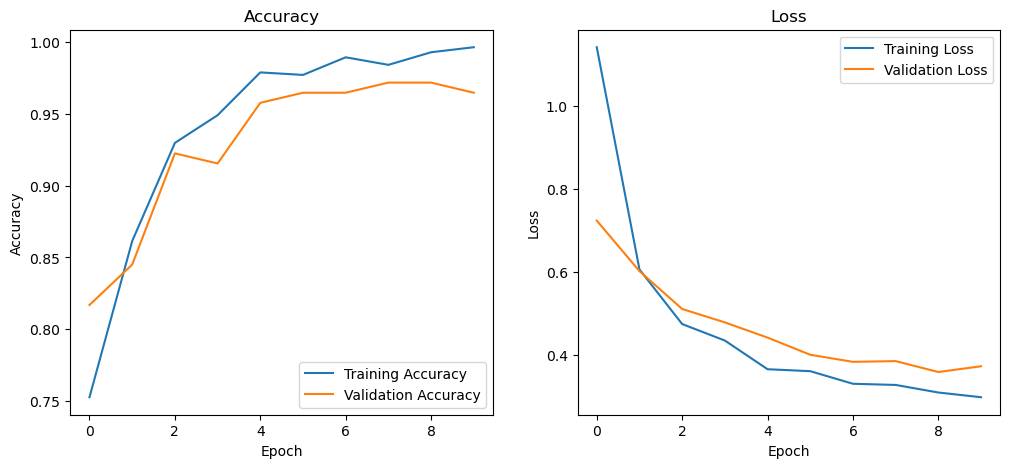

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9783 - loss: 0.3319
Test Accuracy: 0.96 Test Loss: 0.37


In [16]:
"""
Plot Accuracy & Loss for each Epoch
"""
plt.figure(figsize=(12, 5))

# Epoch vs Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"],     label="Training Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy")

# Epoch vs Loss
plt.subplot(1, 2, 2)
plt.plot(history.history["loss"],     label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss")

# Ensure directory exists
os.makedirs(MODEL_NAME, exist_ok=True)

plt.savefig(os.path.join(MODEL_NAME, "history.png"))
plt.show()

# Show Overall Performance
test_loss, test_acc = best_model.evaluate(validation_dataset)
print(f"Test Accuracy: {test_acc:.2f} Test Loss: {test_loss:.2f}")

In [19]:
"""
Save model and training history
"""
# Ensure directory exists
os.makedirs(MODEL_NAME, exist_ok=True)

with open(os.path.join(MODEL_NAME, "history.json"), "w") as file:
    json.dump(history.history, file)

best_model.save(os.path.join(MODEL_NAME, "model.keras"))

# Section 4 - Model Evaluation using a Confusion Matrix

In this section, we will use the best model from the previous section to create a Confusion Matrix.

In [20]:
"""
Load the model trained using the best hyperparameters
"""
best_model = load_model(os.path.join(MODEL_NAME, "model.keras"))

In [21]:
"""
Predict each image in the test dataset
"""
testing_dataset = image_dataset_from_directory(
    TESTING_DIRECTORY,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
)

actual = []
predictions = []

for batch, labels in validation_dataset:
    results = best_model.predict(batch)  # Get raw predictions
    predicted_labels = (results > 0.5).astype(int).flatten()  # Convert probabilities to 0s and 1s
    predictions.extend(predicted_labels)  # Append predicted labels
    actual.extend(labels.numpy())  # Convert actual labels to list

print("Actual Labels:   ", actual)
print("Predicted Labels:", predictions)

Found 45 files belonging to 2 classes.


2025-03-22 15:51:34.987150: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 576ms/step
Actual Labels:    [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1]
Predicted Labels: [1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 

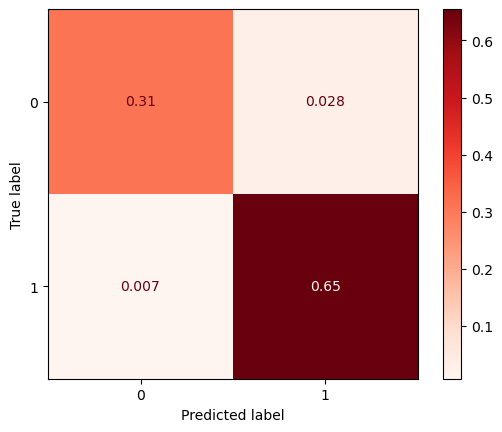

Accuracy: 0.9647887323943662


In [23]:
"""
Plot a Confusion Matrix of the test dataset predictions
"""
result = confusion_matrix(actual, predictions, normalize="all")

disp = ConfusionMatrixDisplay(confusion_matrix=result)
disp.plot(cmap="Reds")

# Ensure directory exists
os.makedirs(MODEL_NAME, exist_ok=True)

plt.savefig(os.path.join(MODEL_NAME, "confusionmatrix.png"))
plt.show()

with open(os.path.join(MODEL_NAME, "confusionmatrix.json"), "w") as file:
    json.dump(result.tolist(), file)

print(f"Accuracy: {result[0][0] + result[1][1]}")

# Section 5 - Model Evaluation using K-Fold Cross Validation

In this section, we will train the model K times with the best hyperparameters identified in section 2. The average accuracy of all folds will be calculated to determine if there is an overfit.

In [25]:
"""
Load the saved GridSearch results
"""
filtered_results = pd.read_csv(os.path.join(MODEL_NAME, "gridsearch.csv"))

# Get the top-ranked result (rank_test_score == 1)
best_result = filtered_results[filtered_results["rank_test_score"] == 1].iloc[0]

# Extract optimizer and learning rate
best_optimizer = best_result["param_model__optimizer"]
best_learning_rate = best_result["param_model__learning_rate"]

best_optimizer, best_learning_rate

('Adam', 0.0001)

In [26]:
"""
Load the training dataset
"""
dataset = image_dataset_from_directory(
    INPUT_DIRECTORY,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
)

Found 712 files belonging to 2 classes.


In [27]:
"""
Prepare the data to be compatible with the K-Folds API
"""

# Function to convert TF dataset to NumPy arrays
def dataset_to_numpy(dataset):
    all_images, all_labels = [], []
    for images, labels in dataset:
        all_images.append(images.numpy())  # Convert images to NumPy
        all_labels.append(labels.numpy())  # Convert labels to NumPy
    return np.vstack(all_images), np.hstack(all_labels)

# Convert datasets for GridSearch compatibility
images, labels = dataset_to_numpy(dataset)

In [28]:
"""
Perform K-Fold Cross-Validation
"""

kf = KFold(n_splits=K_FOLDS, shuffle=True, random_state=42)

fold = 1
accuracies = []

for train_index, val_index in kf.split(images):
    print(f"Training on Fold {fold}/{K_FOLDS}...")

    training_images, validation_images = images[train_index], images[val_index]
    training_labels, validation_labels = labels[train_index], labels[val_index]

    # Define and compile model
    model = create_model(
        optimizer=grid_result.best_params_["model__optimizer"],
        learning_rate=grid_result.best_params_["model__learning_rate"],
    )
    
    history = model.fit(
        training_images,
        training_labels,
        validation_data=(
            validation_images,
            validation_labels
        ),
        epochs=EPOCHS,
        batch_size=BATCH_SIZE
    )
    
    scores = model.evaluate(validation_images, validation_labels, verbose=0)
    print(f"Fold {fold} Accuracy: {scores[1] * 100:.2f}%")
    
    accuracies.append(scores[1] * 100)
    fold += 1

print(f"Average Accuracy: {np.mean(accuracies):.2f}% ± {np.std(accuracies):.2f}%")

Training on Fold 1/5...
Epoch 1/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 15s 273ms/step - accuracy: 0.7459 - loss: 1.1022 - val_accuracy: 0.7762 - val_loss: 1.4673
Epoch 2/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 143ms/step - accuracy: 0.8767 - loss: 0.5731 - val_accuracy: 0.8951 - val_loss: 0.6255
Epoch 3/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 142ms/step - accuracy: 0.9560 - loss: 0.4386 - val_accuracy: 0.9161 - val_loss: 0.5540
Epoch 4/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 140ms/step - accuracy: 0.9781 - loss: 0.3742 - val_accuracy: 0.9301 - val_loss: 0.4668
Epoch 5/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 140ms/step - accuracy: 0.9831 - loss: 0.3483 - val_accuracy: 0.9510 - val_loss: 0.4339
Epoch 6/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 8s 223ms/step - accuracy: 0.9729 - loss: 0.3489 - val_accuracy: 0.9371 - val_loss: 0.4204
Epoch 7/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 140ms/step - accuracy: 0.9912 - loss: 0.3303 - val_accuracy: 0.9441 - val_loss: 0.4116
Epoch 8/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 137ms/step - accuracy: 0.9920 - loss: 

2025-03-22 15:53:03.395763: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


36/36 ━━━━━━━━━━━━━━━━━━━━ 12s 236ms/step - accuracy: 0.7523 - loss: 1.1149 - val_accuracy: 0.5105 - val_loss: 3.3259
Epoch 2/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 148ms/step - accuracy: 0.8480 - loss: 0.6363 - val_accuracy: 0.8322 - val_loss: 0.6449
Epoch 3/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 144ms/step - accuracy: 0.9358 - loss: 0.4681 - val_accuracy: 0.8881 - val_loss: 0.5469
Epoch 4/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 141ms/step - accuracy: 0.9545 - loss: 0.4252 - val_accuracy: 0.9371 - val_loss: 0.4652
Epoch 5/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 143ms/step - accuracy: 0.9522 - loss: 0.3945 - val_accuracy: 0.9510 - val_loss: 0.4141
Epoch 6/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 140ms/step - accuracy: 0.9860 - loss: 0.3455 - val_accuracy: 0.9510 - val_loss: 0.3921
Epoch 7/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 144ms/step - accuracy: 0.9877 - loss: 0.3363 - val_accuracy: 0.9650 - val_loss: 0.3778
Epoch 8/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 140ms/step - accuracy: 0.9856 - loss: 0.3381 - val_accuracy: 0.9510 - val

2025-03-22 15:54:12.203500: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


36/36 ━━━━━━━━━━━━━━━━━━━━ 11s 233ms/step - accuracy: 0.7278 - loss: 1.1897 - val_accuracy: 0.7817 - val_loss: 1.0252
Epoch 2/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 142ms/step - accuracy: 0.8822 - loss: 0.5744 - val_accuracy: 0.7817 - val_loss: 0.8324
Epoch 3/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 142ms/step - accuracy: 0.9302 - loss: 0.4634 - val_accuracy: 0.8521 - val_loss: 0.5950
Epoch 4/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 139ms/step - accuracy: 0.9512 - loss: 0.4255 - val_accuracy: 0.8803 - val_loss: 0.5246
Epoch 5/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 143ms/step - accuracy: 0.9705 - loss: 0.4052 - val_accuracy: 0.9437 - val_loss: 0.4613
Epoch 6/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 138ms/step - accuracy: 0.9713 - loss: 0.3568 - val_accuracy: 0.9577 - val_loss: 0.4408
Epoch 7/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 141ms/step - accuracy: 0.9803 - loss: 0.3328 - val_accuracy: 0.8732 - val_loss: 0.5234
Epoch 8/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 142ms/step - accuracy: 0.9777 - loss: 0.3295 - val_accuracy: 0.9014 - val

2025-03-22 15:55:57.663860: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


36/36 ━━━━━━━━━━━━━━━━━━━━ 11s 221ms/step - accuracy: 0.6891 - loss: 1.3126 - val_accuracy: 0.8169 - val_loss: 1.0729
Epoch 2/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 146ms/step - accuracy: 0.8955 - loss: 0.5690 - val_accuracy: 0.8944 - val_loss: 0.5424
Epoch 3/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 146ms/step - accuracy: 0.9549 - loss: 0.4304 - val_accuracy: 0.8873 - val_loss: 0.5602
Epoch 4/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 142ms/step - accuracy: 0.9503 - loss: 0.4098 - val_accuracy: 0.9155 - val_loss: 0.4756
Epoch 5/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 142ms/step - accuracy: 0.9833 - loss: 0.3605 - val_accuracy: 0.9366 - val_loss: 0.4309
Epoch 6/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 140ms/step - accuracy: 0.9836 - loss: 0.3382 - val_accuracy: 0.9296 - val_loss: 0.4362
Epoch 7/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 140ms/step - accuracy: 0.9860 - loss: 0.3272 - val_accuracy: 0.9437 - val_loss: 0.4247
Epoch 8/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 146ms/step - accuracy: 0.9817 - loss: 0.3374 - val_accuracy: 0.9296 - val

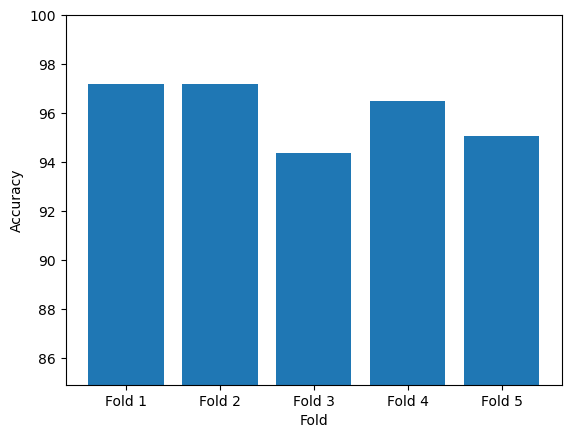

Average Accuracy: 96.06% ± 1.15%


In [29]:
"""
Plot the accuracy for each fold
"""

plt.bar([f"Fold {n}" for n in range(1, K_FOLDS + 1)], accuracies)

# Auto-rescale the bars
plt.ylim(
    min(accuracies) * 0.9,          # 0.9 to make the smallest bar still visible
    min(max(accuracies) * 1.1, 100) # 1.1 to make extra space above the  largest bar
)
plt.xlabel("Fold")
plt.ylabel("Accuracy")

# Ensure directory exists
os.makedirs(MODEL_NAME, exist_ok=True)

plt.savefig(os.path.join(MODEL_NAME, "kfold.png"))
plt.show()

print(f"Average Accuracy: {np.mean(accuracies):.2f}% ± {np.std(accuracies):.2f}%")

In [30]:
"""
Save K-Fold score
"""
# Ensure directory exists
os.makedirs(MODEL_NAME, exist_ok=True)

with open(os.path.join(MODEL_NAME, "kfold.json"), "w") as file:
    json.dump(accuracies, file)